In [1]:
## Import packages
import os
import mne
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt

from scipy.signal import butter, sosfiltfilt, sosfreqz  
from scipy.io import loadmat

In [2]:
## For visualization
import PyQt5
%matplotlib qt

In [3]:
## Define directories
data_dir = '/home/inffzy/Desktop/cogs189/cogs189_final_project/data'

In [4]:
## Raw data directory names
bc3_3a_raw_name = 'bci_competition_3_3a_raw'
bc3_4a_raw_name = 'bci_competition_3_4a_raw'
bc4_2a_raw_name = 'bci_competition_4_2a_raw'

bc3_3a_processed_name = 'bci_competition_3_3a_processed'
bc3_4a_processed_name = 'bci_competition_3_4a_processed'
bc4_2a_processed_name = 'bci_competition_4_2a_processed'

## Process BCI Competition Dataset 4_2a

In [5]:
## Define directory
bc4_2a_raw_dir = os.path.join(data_dir, bc4_2a_raw_name)
bc4_2a_processed_dir = os.path.join(data_dir, bc4_2a_processed_name)

if not os.path.isdir(bc4_2a_processed_dir):
    os.mkdir(bc4_2a_processed_dir)

In [6]:
## Define constants
num_subjects = 9
num_channels = 22
sampling_f = 250  ## Hz
baseline_duration = 2  ## seconds
motor_imagery_start = 3.5  ## seconds after trial begins
motor_imagery_end = 5.5  ## seconds after trial begins
motor_imagery_trial_duration = int(motor_imagery_end - motor_imagery_start)  ## seconds

In [7]:
## Create filter
order = 6
lower_passband = 7
upper_passband = 30
sos = butter(order, 
             [lower_passband, upper_passband], 
             analog = False, 
             btype = 'band', 
             output = 'sos', 
             fs = sampling_f)

In [8]:
for idx_subject in range(1, 10):
    
    ## Load subject dataset with MNE
    subject_name = 'A0' + str(idx_subject) + 'T'
    subject_path = os.path.join(bc4_2a_raw_dir, subject_name + '.gdf')
    subject_mne = mne.io.read_raw_gdf(subject_path)
    raw_data = subject_mne.get_data()[:num_channels, :]
    
    ## Access annotations
    annotations = subject_mne.annotations
    annotations_list = list(annotations)
    
    ## Convert annotation dictionary into lists
    descriptions = []
    onsets = []

    for i in range(len(annotations_list) - 1):
        
        description_cur = annotations_list[i]['description']
        description_next = annotations_list[i + 1]['description']
        
        ## Check if the current trial is valid and has a known cue
        if description_cur == '768' and description_next in ['769', '770', '771', '772']:    
            onsets.append(annotations_list[i]['onset'])
            descriptions.append(int(description_next))
    
    descriptions = np.array(descriptions)
    onsets = np.array(onsets)
    
    ## Process by onsets to create epochs
    num_valid_trials = onsets.shape[0]

    ## Initialize processed data array
    processed_motor_imagery_data = np.zeros((num_valid_trials,
                                             num_channels,
                                             motor_imagery_trial_duration * sampling_f))
    
    for idx_trial in range(num_valid_trials):
        
        ## Epoching
        onset_time = onsets[idx_trial]
        onset_index = int(onset_time * sampling_f)
        
        motor_imagery_start_time = onset_time + motor_imagery_start        
        motor_imagery_start_index = int(motor_imagery_start_time * sampling_f)
        motor_imagery_end_index = motor_imagery_start_index + motor_imagery_trial_duration * sampling_f
        
        motor_imagery_data = raw_data[:, motor_imagery_start_index:motor_imagery_end_index]
        
        ## DC correction
        motor_imagery_data_mean = np.mean(motor_imagery_data, axis=1).reshape((num_channels, 1))
        motor_imagery_data = motor_imagery_data - motor_imagery_data_mean
        
        ## Filtering (band pass to 7~30 Hz)
        motor_imagery_data = sosfiltfilt(sos, motor_imagery_data, axis=1)
        
        ## Baseline correction
        baseline_end_index = onset_index + baseline_duration * sampling_f
        
        baseline_data = raw_data[:, onset_index:baseline_end_index]
        baseline_data_mean = np.mean(baseline_data, axis=1).reshape((num_channels, 1))
        motor_imagery_data = motor_imagery_data - baseline_data_mean
        
        ## Store processed motor imagery data
        processed_motor_imagery_data[idx_trial, :, :] = motor_imagery_data
    
    
    ## Export processed motor imagery data
    processed_subject_path = os.path.join(bc4_2a_processed_dir, subject_name + '.npz')
    np.savez(processed_subject_path, 
             processed_motor_imagery_data=processed_motor_imagery_data, 
             descriptions=descriptions, 
             onsets=onsets)
    
    print('Finished processing subject dataset ', idx_subject)

Extracting EDF parameters from /home/inffzy/Desktop/cogs189/cogs189_final_project/data/bci_competition_4_2a_raw/A01T.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG, EOG-left, EOG-central, EOG-right
Creating raw.info structure...


/home/inffzy/.conda/envs/cogs189/lib/python3.9/site-packages/mne/io/edf/edf.py:1131: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, UINT8).tolist()[0]
/home/inffzy/.conda/envs/cogs189/lib/python3.9/contextlib.py:126: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


Finished processing subject dataset  1
Extracting EDF parameters from /home/inffzy/Desktop/cogs189/cogs189_final_project/data/bci_competition_4_2a_raw/A02T.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG, EOG-left, EOG-central, EOG-right
Creating raw.info structure...


/home/inffzy/.conda/envs/cogs189/lib/python3.9/site-packages/mne/io/edf/edf.py:1131: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, UINT8).tolist()[0]
/home/inffzy/.conda/envs/cogs189/lib/python3.9/contextlib.py:126: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


Finished processing subject dataset  2
Extracting EDF parameters from /home/inffzy/Desktop/cogs189/cogs189_final_project/data/bci_competition_4_2a_raw/A03T.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG, EOG-left, EOG-central, EOG-right
Creating raw.info structure...


/home/inffzy/.conda/envs/cogs189/lib/python3.9/site-packages/mne/io/edf/edf.py:1131: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, UINT8).tolist()[0]
/home/inffzy/.conda/envs/cogs189/lib/python3.9/contextlib.py:126: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


Finished processing subject dataset  3
Extracting EDF parameters from /home/inffzy/Desktop/cogs189/cogs189_final_project/data/bci_competition_4_2a_raw/A04T.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG, EOG-left, EOG-central, EOG-right
Creating raw.info structure...


/home/inffzy/.conda/envs/cogs189/lib/python3.9/site-packages/mne/io/edf/edf.py:1131: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, UINT8).tolist()[0]
/home/inffzy/.conda/envs/cogs189/lib/python3.9/contextlib.py:126: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


Finished processing subject dataset  4
Extracting EDF parameters from /home/inffzy/Desktop/cogs189/cogs189_final_project/data/bci_competition_4_2a_raw/A05T.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG, EOG-left, EOG-central, EOG-right
Creating raw.info structure...


/home/inffzy/.conda/envs/cogs189/lib/python3.9/site-packages/mne/io/edf/edf.py:1131: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, UINT8).tolist()[0]
/home/inffzy/.conda/envs/cogs189/lib/python3.9/contextlib.py:126: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


Finished processing subject dataset  5
Extracting EDF parameters from /home/inffzy/Desktop/cogs189/cogs189_final_project/data/bci_competition_4_2a_raw/A06T.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG, EOG-left, EOG-central, EOG-right
Creating raw.info structure...


/home/inffzy/.conda/envs/cogs189/lib/python3.9/site-packages/mne/io/edf/edf.py:1131: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, UINT8).tolist()[0]
/home/inffzy/.conda/envs/cogs189/lib/python3.9/contextlib.py:126: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


Finished processing subject dataset  6
Extracting EDF parameters from /home/inffzy/Desktop/cogs189/cogs189_final_project/data/bci_competition_4_2a_raw/A07T.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG, EOG-left, EOG-central, EOG-right
Creating raw.info structure...


/home/inffzy/.conda/envs/cogs189/lib/python3.9/site-packages/mne/io/edf/edf.py:1131: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, UINT8).tolist()[0]
/home/inffzy/.conda/envs/cogs189/lib/python3.9/contextlib.py:126: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


Finished processing subject dataset  7
Extracting EDF parameters from /home/inffzy/Desktop/cogs189/cogs189_final_project/data/bci_competition_4_2a_raw/A08T.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG, EOG-left, EOG-central, EOG-right
Creating raw.info structure...


/home/inffzy/.conda/envs/cogs189/lib/python3.9/site-packages/mne/io/edf/edf.py:1131: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, UINT8).tolist()[0]
/home/inffzy/.conda/envs/cogs189/lib/python3.9/contextlib.py:126: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


Finished processing subject dataset  8
Extracting EDF parameters from /home/inffzy/Desktop/cogs189/cogs189_final_project/data/bci_competition_4_2a_raw/A09T.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG, EOG-left, EOG-central, EOG-right
Creating raw.info structure...


/home/inffzy/.conda/envs/cogs189/lib/python3.9/site-packages/mne/io/edf/edf.py:1131: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, UINT8).tolist()[0]
/home/inffzy/.conda/envs/cogs189/lib/python3.9/contextlib.py:126: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


Finished processing subject dataset  9


In [9]:
## Verify processed data
processed_dataset_path = os.path.join(bc4_2a_processed_dir, 'A01T.npz')
processed_dataset_npz = np.load(processed_dataset_path)
print(processed_dataset_npz.files)
print(processed_dataset_npz['processed_motor_imagery_data'].shape)

['processed_motor_imagery_data', 'descriptions', 'onsets']
(273, 22, 500)


## Process BCI Competition Dataset 3_3a

In [10]:
## Define directory
bc3_3a_raw_dir = os.path.join(data_dir, bc3_3a_raw_name)
bc3_3a_processed_dir = os.path.join(data_dir, bc3_3a_processed_name)

if not os.path.isdir(bc3_3a_processed_dir):
    os.mkdir(bc3_3a_processed_dir)

In [11]:
## Define constants
num_subjects = 3
num_channels = 60
sampling_f = 250  ## Hz
baseline_duration = 2  ## seconds
motor_imagery_start = 4.5  ## seconds after trial begins
motor_imagery_end = 6.5  ## seconds after trial begins
motor_imagery_trial_duration = int(motor_imagery_end - motor_imagery_start)  ## seconds

## Note: for the 3_3a dataset, the training time span is technically 3s to 7s.
##   but since no break is given, and reaction time is not accounted for, we use 4.5s to 6.5s, 
##   making a duration of 2s, same as 4_2a 

In [12]:
## Create filter
order = 6
lower_passband = 7
upper_passband = 30
sos = butter(order, 
             [lower_passband, upper_passband], 
             analog = False, 
             btype = 'band', 
             output = 'sos', 
             fs = sampling_f)

In [13]:
subject_dir_names = ['subject1_k3b', 'subject2_k6b', 'subject3_l1b']


for idx_subject, subject_dir_name in enumerate(subject_dir_names):
    idx_subject += 1
    
    ## Load subject dataset with MNE
    subject_dir = os.path.join(bc3_3a_raw_dir, subject_dir_name)
    subject_name = 'bc3_3a_s' + str(idx_subject)
    subject_path_gdf = os.path.join(subject_dir, subject_name + '.gdf')
    subject_mne = mne.io.read_raw_gdf(subject_path_gdf)
    raw_data = subject_mne.get_data()
    
    ## Access annotations
    annotations = subject_mne.annotations
    annotations_list = list(annotations)
    
    ## Convert annotation dictionary into lists
    descriptions = []
    onsets = []
    onset_trial = -1
    valid_trial = True
    total_trial_count = 0
    rejected_trial_count = 0
    unknown_cue_count = 0
    
    for i in range(len(annotations_list)):
        
        description_cur = annotations_list[i]['description']
        onset_cur = annotations_list[i]['onset']
        
        if description_cur == '768':
            valid_trial = True
            onset_trial = onset_cur
            total_trial_count += 1
            
        elif description_cur == '1023':
            valid_trial = False
            rejected_trial_count += 1
            
        elif valid_trial: 
            if description_cur in ['769', '770', '771', '772']:
                descriptions.append(int(description_cur))
                onsets.append(onset_trial)
            elif description_cur == '783':
                unknown_cue_count += 1
            
    descriptions = np.array(descriptions)
    onsets = np.array(onsets)
    num_valid_trials = onsets.shape[0]
    
    print('Finished processing annotation for subject', idx_subject)
    print('\tTotoal trial count: ', total_trial_count)
    print('\tRejected trial count: ', rejected_trial_count)
    print('\tUnknown cue count: ', unknown_cue_count)
    print('\tNumber of valid trials: ', num_valid_trials)
    
    ## Process by onsets to create epochs
    
    ## Initialize processed data array
    processed_motor_imagery_data = np.zeros((num_valid_trials, 
                                            num_channels,
                                            int(motor_imagery_trial_duration * sampling_f)))
    
    for idx_trial in range(num_valid_trials):
        
        ## Epoching
        onset_time = onsets[idx_trial]
        onset_index = int(onset_time * sampling_f)
        
        motor_imagery_start_time = onset_time + motor_imagery_start        
        motor_imagery_start_index = int(motor_imagery_start_time * sampling_f)
        motor_imagery_end_index = motor_imagery_start_index + int(motor_imagery_trial_duration * sampling_f)
      
        motor_imagery_data = raw_data[:, motor_imagery_start_index:motor_imagery_end_index]
        
        ## DC correction
        motor_imagery_data_mean = np.mean(motor_imagery_data, axis=1).reshape((num_channels, 1))
        motor_imagery_data = motor_imagery_data - motor_imagery_data_mean
        
        ## Filtering (band pass to 7~30 Hz)
        motor_imagery_data = sosfiltfilt(sos, motor_imagery_data, axis=1)
        
        ## Baseline correction
        baseline_end_index = onset_index + baseline_duration * sampling_f
        
        baseline_data = raw_data[:, onset_index:baseline_end_index]
        baseline_data_mean = np.mean(baseline_data, axis=1).reshape((num_channels, 1))
        motor_imagery_data = motor_imagery_data - baseline_data_mean
        
        ## Store processed motor imagery data
        processed_motor_imagery_data[idx_trial, :, :] = motor_imagery_data
    
    
    ## Export processed motor imagery data
    processed_subject_path = os.path.join(bc3_3a_processed_dir, subject_name + '.npz')
    np.savez(processed_subject_path, 
             processed_motor_imagery_data=processed_motor_imagery_data, 
             descriptions=descriptions, 
             onsets=onsets)
    
    print('Finished processing subject dataset ', idx_subject)

Extracting EDF parameters from /home/inffzy/Desktop/cogs189/cogs189_final_project/data/bci_competition_3_3a_raw/subject1_k3b/bc3_3a_s1.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
#  1, #  2, #  3, #  4, #  5, #  6, #  7, #  8, #  9, # 10, # 11, # 12, # 13, # 14, # 15, # 16, # 17, # 18, # 19, # 20, # 21, # 22, # 23, # 24, # 25, # 26, # 27, # 28, # 29, # 30, # 31, # 32, # 33, # 34, # 35, # 36, # 37, # 38, # 39, # 40, # 41, # 42, # 43, # 44, # 45, # 46, # 47, # 48, # 49, # 50, # 51, # 52, # 53, # 54, # 55, # 56, # 57, # 58, # 59, # 60
Creating raw.info structure...
Finished processing annotation for subject 1
	Totoal trial count:  360
	Rejected trial count:  62
	Unknown cue count:  149
	Number of valid trials:  149
Finished processing subject dataset  1
Extracting EDF parameters from /home/inffzy/Desktop/cogs189/cogs189_final_project/data/bci_competition_3_3a_raw/subject2_k6b/bc3_3a_s2.gdf.

In [14]:
## Verify processed data
processed_dataset_path = os.path.join(bc3_3a_processed_dir, 'bc3_3a_s1.npz')
processed_dataset_npz = np.load(processed_dataset_path)
print(processed_dataset_npz.files)
print(processed_dataset_npz['processed_motor_imagery_data'].shape)

['processed_motor_imagery_data', 'descriptions', 'onsets']
(149, 60, 500)


## Process BCI Competition Dataset 3_4a

**Note:** We will not use this dataset for now

## Explore BCI Competition Dataset 4_2a

In [15]:
## Examine A01T.gdf with MNE
bc4_2a_raw_dir = os.path.join(data_dir, bc4_2a_raw_name)
A01T_path = os.path.join(bc4_2a_raw_dir, 'A01T.gdf')
A01T = mne.io.read_raw_gdf(A01T_path)

Extracting EDF parameters from /home/inffzy/Desktop/cogs189/cogs189_final_project/data/bci_competition_4_2a_raw/A01T.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG, EOG-left, EOG-central, EOG-right
Creating raw.info structure...


/home/inffzy/.conda/envs/cogs189/lib/python3.9/site-packages/mne/io/edf/edf.py:1131: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, UINT8).tolist()[0]
/home/inffzy/.conda/envs/cogs189/lib/python3.9/contextlib.py:126: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


In [16]:
A01T

<RawGDF | A01T.gdf, 25 x 672528 (2690.1 s), ~28 kB, data not loaded>

In [17]:
## Print channel names
A01T.ch_names

['EEG-Fz',
 'EEG-0',
 'EEG-1',
 'EEG-2',
 'EEG-3',
 'EEG-4',
 'EEG-5',
 'EEG-C3',
 'EEG-6',
 'EEG-Cz',
 'EEG-7',
 'EEG-C4',
 'EEG-8',
 'EEG-9',
 'EEG-10',
 'EEG-11',
 'EEG-12',
 'EEG-13',
 'EEG-14',
 'EEG-Pz',
 'EEG-15',
 'EEG-16',
 'EOG-left',
 'EOG-central',
 'EOG-right']

In [18]:
## Print raw data and shape
A01T_raw_data = A01T.get_data()
print(A01T_raw_data)
print(A01T_raw_data.shape)

[[-2.11425781e-05 -2.19238281e-05 -1.56250000e-05 ...  5.51757812e-06
   1.46484375e-06  1.36718750e-06]
 [-2.36816406e-05 -2.39257812e-05 -1.97265625e-05 ...  1.04980469e-05
   3.07617188e-06  3.51562500e-06]
 [-2.14843750e-05 -2.43164062e-05 -1.88476562e-05 ...  1.49414062e-05
   9.22851563e-06  7.86132812e-06]
 ...
 [ 3.17382813e-05  2.24609375e-05  3.36914062e-05 ...  6.34765625e-06
  -4.39453125e-06 -4.39453125e-06]
 [-1.36718750e-05 -1.31835937e-05 -8.30078125e-06 ... -3.71093750e-05
  -4.78515625e-05 -4.54101562e-05]
 [-4.39453125e-05 -4.05273437e-05 -3.85742188e-05 ...  1.66015625e-05
   1.26953125e-05  7.81250000e-06]]
(25, 672528)


Using matplotlib as 2D backend.


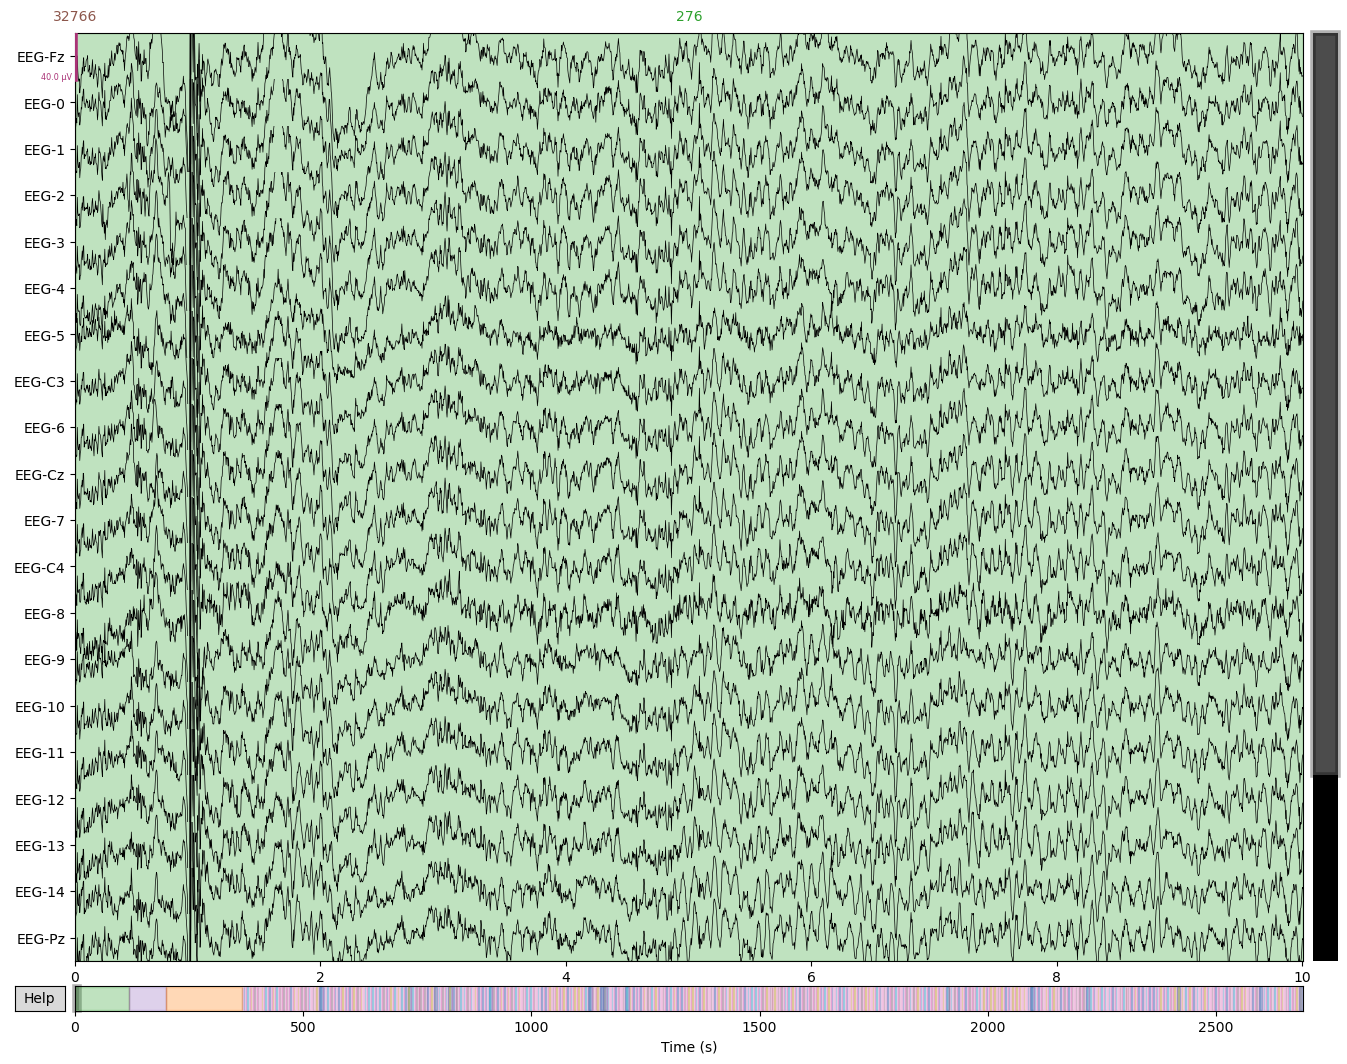

In [19]:
## Visualize data
A01T.plot()

In [20]:
## Examine annotations
A01T_annotations = A01T.annotations
A01T_annotations_list = list(A01T_annotations)
A01T_annotations_list

[OrderedDict([('onset', 0.0),
              ('duration', 0.004),
              ('description', '32766'),
              ('orig_time',
               datetime.datetime(2005, 1, 17, 12, 0, tzinfo=datetime.timezone.utc))]),
 OrderedDict([('onset', 0.0),
              ('duration', 118.728),
              ('description', '276'),
              ('orig_time',
               datetime.datetime(2005, 1, 17, 12, 0, tzinfo=datetime.timezone.utc))]),
 OrderedDict([('onset', 118.732),
              ('duration', 0.004),
              ('description', '32766'),
              ('orig_time',
               datetime.datetime(2005, 1, 17, 12, 0, tzinfo=datetime.timezone.utc))]),
 OrderedDict([('onset', 118.732),
              ('duration', 81.084),
              ('description', '277'),
              ('orig_time',
               datetime.datetime(2005, 1, 17, 12, 0, tzinfo=datetime.timezone.utc))]),
 OrderedDict([('onset', 199.82),
              ('duration', 0.004),
              ('description', '32766'),
     

In [21]:
## Convert annotation dictionary into lists
A01T_trial_onsets = []
A01T_trial_durations = []
A01T_trial_descriptions = []

for i in range(len(A01T_annotations_list) - 1):
    
    description_cur = A01T_annotations_list[i]['description']
    description_next = A01T_annotations_list[i + 1]['description']
    
    ## Check if the current trial is valid and has a known cue
    if description_cur == '768' and description_next in ['769', '770', '771', '772']:    
        A01T_trial_onsets.append(A01T_annotations_list[i]['onset'])
        A01T_trial_durations.append(A01T_annotations_list[i]['duration'])
        A01T_trial_descriptions.append(int(description_next))

        
A01T_trial_descriptions = np.array(A01T_trial_descriptions)

In [22]:
A01T_trial_descriptions

array([772, 771, 770, 769, 769, 770, 771, 772, 770, 771, 769, 769, 769,
       772, 770, 770, 769, 769, 771, 769, 770, 772, 771, 769, 772, 772,
       770, 772, 772, 770, 769, 770, 771, 771, 771, 772, 771, 769, 772,
       770, 771, 770, 771, 772, 771, 769, 769, 769, 772, 770, 771, 769,
       771, 772, 769, 771, 771, 769, 771, 770, 772, 772, 772, 769, 772,
       770, 772, 770, 769, 771, 770, 769, 771, 771, 769, 771, 772, 772,
       770, 769, 770, 772, 770, 772, 771, 770, 770, 770, 771, 769, 770,
       771, 771, 772, 769, 769, 770, 772, 772, 772, 770, 769, 771, 770,
       772, 769, 772, 771, 770, 772, 772, 769, 770, 770, 771, 772, 770,
       769, 769, 772, 770, 769, 771, 770, 770, 771, 769, 772, 771, 771,
       771, 771, 769, 770, 769, 770, 769, 769, 771, 771, 770, 771, 772,
       769, 772, 769, 769, 770, 772, 771, 770, 772, 771, 772, 771, 772,
       770, 770, 772, 769, 770, 770, 770, 771, 772, 769, 772, 769, 771,
       769, 772, 769, 771, 769, 770, 771, 771, 772, 769, 770, 77

Channels marked as bad: none
